<a href="https://colab.research.google.com/github/pvihung/Spotify_Analysis/blob/main/SpotifyAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
file_path = 'sample_data/Spotify_Youtube.csv'
df = pd.read_csv(file_path,)
df.info()

df
# normalize streams to values between 0 and 1.
min_value, max_value = df["Stream"].min(), df["Stream"].max()
df["Stream"] = (df["Stream"] - min_value) / (max_value - min_value)
print(df["Stream"])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20594 entries, 0 to 20593
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Artist            20594 non-null  object 
 1   Track             20594 non-null  object 
 2   Album             20594 non-null  object 
 3   Album_type        20594 non-null  object 
 4   Danceability      20594 non-null  float64
 5   Energy            20594 non-null  float64
 6   Loudness          20594 non-null  float64
 7   Speechiness       20594 non-null  float64
 8   Acousticness      20594 non-null  float64
 9   Instrumentalness  20594 non-null  float64
 10  Liveness          20594 non-null  float64
 11  Valence           20594 non-null  float64
 12  Tempo             20594 non-null  float64
 13  Duration_min      20594 non-null  float64
 14  Title             20594 non-null  object 
 15  Channel           20594 non-null  object 
 16  Views             20594 non-null  float6

In [2]:
#df.drop(columns=['Unnamed: 0','Url_spotify','Uri','Url_youtube','Description'], inplace=True)

In [3]:
df.Licensed.unique()
df.official_video.value_counts()
df.Stream.value_counts(ascending=True)


Stream
0.307169      1
0.033565      1
0.070744      1
0.045929      1
0.038170      1
           ... 
0.002953      9
0.016359      9
0.026418     19
0.050131     24
0.000000    576
Name: count, Length: 18339, dtype: int64

#1. Do high-tempo songs garner more streams?

In [4]:
df.Tempo.value_counts()

Tempo
77.986     24
106.002    19
0.000      19
120.031    12
119.982    11
           ..
82.525      1
82.499      1
89.901      1
82.879      1
155.378     1
Name: count, Length: 14954, dtype: int64

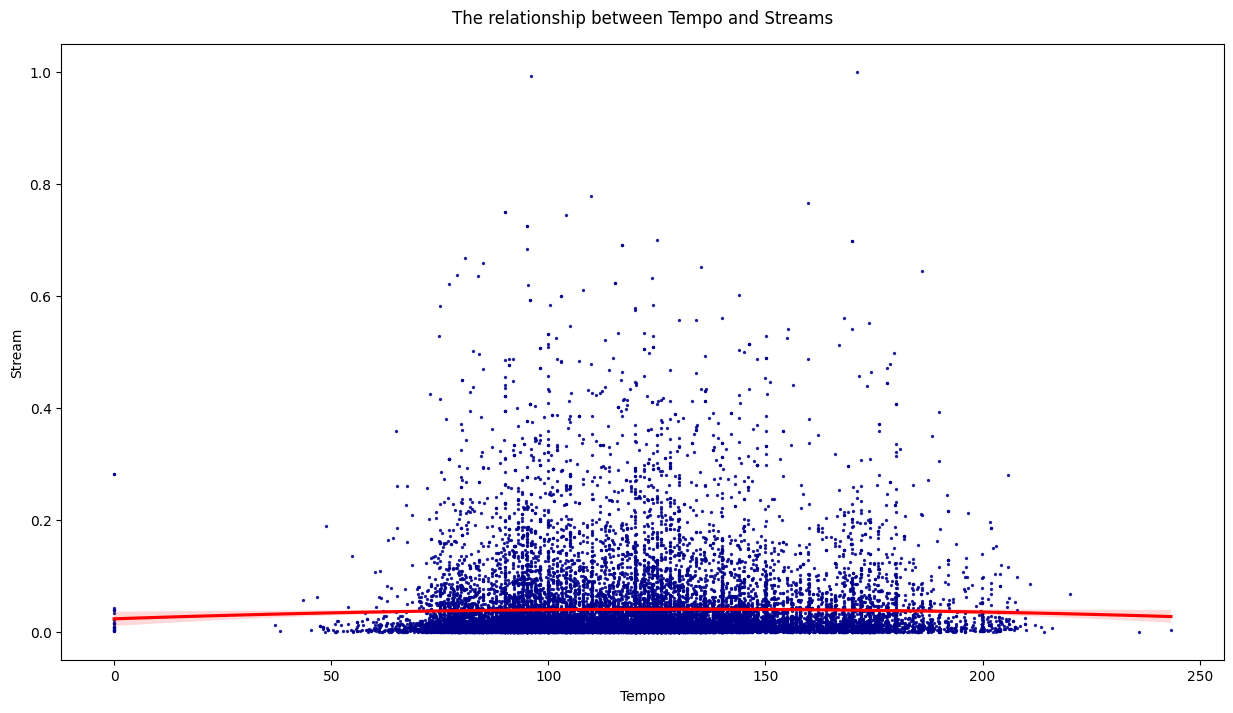

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

question_1 = sns.regplot(
    data=df,
    x='Tempo',
    y='Stream',
    scatter_kws={'s':2,'color':'darkblue'},
    order=2,
    line_kws={'color':'red'}
)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('The relationship between Tempo and Streams', y=1.02)
plt.xlabel('Tempo')
plt.ylabel('Stream')
plt.show()

# We can say that Tempo is not a factor to determine a song will more likely to get a song or not


#2. Do songs with longer or shorter titles have more streams?


In [6]:
df.Title.value_counts()
title_length=df.Title.str.len()
title_length.mean()
df['Title_length']=title_length
df.Title_length.value_counts()

Title_length
46     482
1      469
47     468
44     466
41     465
      ... 
188      4
3        4
176      1
116      1
101      1
Name: count, Length: 103, dtype: int64

Text(0, 0.5, 'Stream')

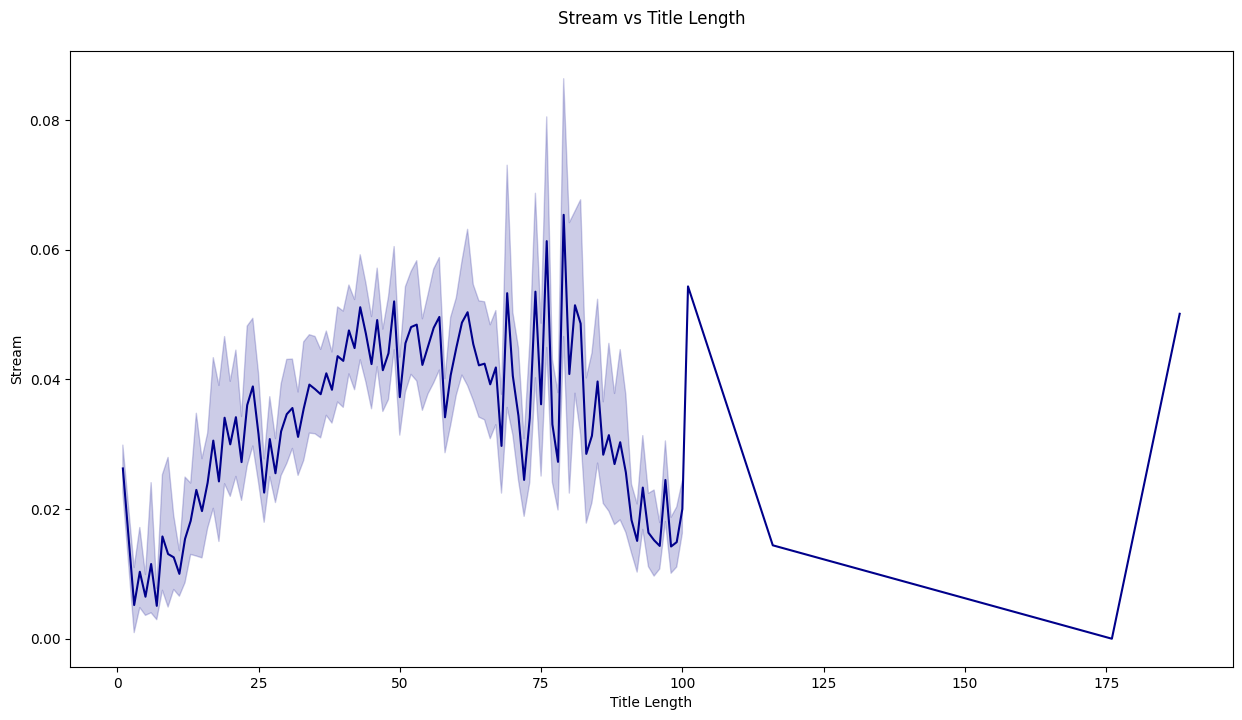

In [7]:
sns.lineplot(
    data = df,
    x = 'Title_length',
    y = 'Stream',
    color = 'darkblue'
)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Stream vs Title Length', y=1.03)
plt.xlabel('Title Length')
plt.ylabel('Stream')

In [8]:
# what traits make a loud vs quiet song widely streamed?
# quiet songs are one or more stddevs below the mean, opposite for loud songs

std_dev = df['Loudness'].std()
quiet_df = df[df['Loudness'] <= df['Loudness'].mean() - std_dev]
loud_df = df[df['Loudness'] >= df['Loudness'].mean() + std_dev]

correlation_matrix = quiet_df.select_dtypes(include='number').corr()
quiet_correlations = correlation_matrix['Stream']

correlation_matrix = loud_df.select_dtypes(include='number').corr()
loud_correlations = correlation_matrix['Stream']

print(quiet_correlations)
print(loud_correlations)

# weak correlations between any song trait and stream, aside from comments likes and views
# Comments, likes, and views already tell us a song is popular though, so they aren't useful
# quiet songs correlate loudness with streams, while loud songs have a negative correlation between loudness and streams
# suggests that moderate values in the dataset may maximize streams

Danceability        0.094824
Energy              0.051469
Loudness            0.157530
Speechiness        -0.092914
Acousticness       -0.096420
Instrumentalness   -0.162610
Liveness           -0.039610
Valence             0.063149
Tempo               0.028379
Duration_min        0.019094
Views               0.343118
Likes               0.451655
Comments            0.425853
Stream              1.000000
EnergyLiveness      0.104774
Title_length       -0.033883
Name: Stream, dtype: float64
Danceability        0.046480
Energy             -0.105700
Loudness           -0.114038
Speechiness        -0.018842
Acousticness       -0.065360
Instrumentalness   -0.035868
Liveness           -0.072627
Valence            -0.030596
Tempo              -0.064597
Duration_min        0.008699
Views               0.621201
Likes               0.690111
Comments            0.270929
Stream              1.000000
EnergyLiveness      0.028314
Title_length        0.019390
Name: Stream, dtype: float64


In [9]:
#Which combinations of valence and tempo create the most streamed songs?
#Are songs with high valence and low tempo most popular, or is it another combination like low valence and high tempo?

def split_by_quartile(df, column_name):
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in DataFrame.")

    quartiles = df[column_name].quantile([0.25, 0.5, 0.75])
    q1 = df[df[column_name] <= quartiles[0.25]]
    q2 = df[(df[column_name] > quartiles[0.25]) & (df[column_name] <= quartiles[0.5])]
    q3 = df[(df[column_name] > quartiles[0.5]) & (df[column_name] <= quartiles[0.75])]
    q4 = df[df[column_name] > quartiles[0.75]]

    return [q1, q2, q3, q4]

# split into quartiles of valence, within those quartiles, split into mini quartiles of tempo
valence_quartiles = split_by_quartile(df, "Valence")

for i, quartile_df in enumerate(valence_quartiles):
    tempo_quartiles = split_by_quartile(quartile_df, "Tempo")
    for j, tq in enumerate(tempo_quartiles):
        print(f"valence quartile {i + 1} tempo quartile {j + 1} median streams: {tq.Stream.median()}")

# valence quartile 2 and tempo quartile 4 is combination listed with the highest median streams

valence quartile 1 tempo quartile 1 median streams: 0.010840236549027283
valence quartile 1 tempo quartile 2 median streams: 0.014335301687700978
valence quartile 1 tempo quartile 3 median streams: 0.014225292602174424
valence quartile 1 tempo quartile 4 median streams: 0.015342898486128898
valence quartile 2 tempo quartile 1 median streams: 0.014211647622646695
valence quartile 2 tempo quartile 2 median streams: 0.01467842527804753
valence quartile 2 tempo quartile 3 median streams: 0.015778650784802267
valence quartile 2 tempo quartile 4 median streams: 0.01748384151419559
valence quartile 3 tempo quartile 1 median streams: 0.012995780995598748
valence quartile 3 tempo quartile 2 median streams: 0.014972454817314828
valence quartile 3 tempo quartile 3 median streams: 0.014876713474453575
valence quartile 3 tempo quartile 4 median streams: 0.014403003924953896
valence quartile 4 tempo quartile 1 median streams: 0.012634397068758975
valence quartile 4 tempo quartile 2 median streams: 0

In [10]:
print(df.describe())

       Danceability        Energy      Loudness   Speechiness  Acousticness  \
count  20594.000000  20594.000000  20594.000000  20594.000000  20594.000000   
mean       0.620102      0.635176     -7.678254      0.096733      0.291391   
std        0.165504      0.214274      4.639481      0.112182      0.286117   
min        0.000000      0.000000    -46.251000      0.000000      0.000000   
25%        0.519000      0.507000     -8.868000      0.035700      0.045200   
50%        0.638000      0.666000     -6.540500      0.050650      0.193000   
75%        0.741000      0.798000     -4.935000      0.104000      0.476750   
max        0.975000      1.000000      0.920000      0.964000      0.996000   

       Instrumentalness      Liveness       Valence         Tempo  \
count      20594.000000  20594.000000  20594.000000  20594.000000   
mean           0.056162      0.193653      0.530077    120.562616   
std            0.193622      0.168832      0.245542     29.588093   
min         

In [40]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns

cols_to_drop = []
for col in df.columns:
    if df[col].dtype == 'object' and col != "Track":
        cols_to_drop.append(col)
cluster_df = df.drop(columns=cols_to_drop)

clustering_kmeans = KMeans(n_clusters=6)
cluster_df = cluster_df.dropna()

cluster_df = cluster_df.drop('Stream', axis=1)
cluster_df = cluster_df.drop('Comments', axis=1)
cluster_df = cluster_df.drop('Likes', axis=1)
cluster_df = cluster_df.drop('Views', axis=1)

#print(cluster_df)
cluster_df['clusters'] = clustering_kmeans.fit_predict(cluster_df.iloc[:, 1:]) # exclude track column
print(cluster_df['clusters'])
print(cluster_df['clusters'].value_counts())


#pca_num_components = 2

#reduced_data = PCA(n_components=pca_num_components).fit_transform(cluster_df)
#results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])

#sns.scatterplot(x="pca1", y="pca2", hue=cluster_df['clusters'], data=results)
#plt.title('K-means Clustering with 2 dimensions')
#plt.show()

# restore df original columns
file_path = 'sample_data/Spotify_Youtube.csv'
df = pd.read_csv(file_path,)

for cluster in cluster_df['clusters'].unique():
    tracks = cluster_df[cluster_df["clusters"] == cluster]
    print(f"Cluster: {cluster}")
    
    for col in tracks.columns.tolist()[1:]:
        print(f"{col}: {tracks[col].median()}")

    median_streams = df[df["Track"].isin(tracks["Track"].tolist())].Stream.median()
    print(f"Stream: {median_streams}\n\n\n")

0        1
1        0
2        0
3        3
4        4
        ..
20589    0
20590    4
20591    4
20592    4
20593    4
Name: clusters, Length: 20592, dtype: int32
clusters
3    5830
0    5482
1    3732
5    2608
4    2107
2     833
Name: count, dtype: int64
Cluster: 1
Danceability: 0.612
Energy: 0.6575
Loudness: -6.6195
Speechiness: 0.04815
Acousticness: 0.197
Instrumentalness: 1.425e-06
Liveness: 0.126
Valence: 0.503
Tempo: 140.09449999999998
Duration_min: 3.5595416666666666
EnergyLiveness: 4.047964113181505
clusters: 1.0
Stream: 49738866.5



Cluster: 0
Danceability: 0.679
Energy: 0.682
Loudness: -6.343500000000001
Speechiness: 0.053
Acousticness: 0.186
Instrumentalness: 1.87e-06
Liveness: 0.126
Valence: 0.575
Tempo: 97.86250000000001
Duration_min: 3.5822166666666666
EnergyLiveness: 4.575774971297359
clusters: 0.0
Stream: 49085426.0



Cluster: 3
Danceability: 0.686
Energy: 0.693
Loudness: -6.373
Speechiness: 0.0466
Acousticness: 0.151
Instrumentalness: 7.495e-06
Liveness: 0.124
Va